In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=float32,force_device=True'
import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

2022-10-17 11:25:38.098899: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Global seed set to 0


In [2]:
tf.test.is_gpu_available()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
2022-10-17 11:25:46.047833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 11:25:46.050721: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-17 11:25:46.052917: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-17 11:25:46.100903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Quadro M2000 computeCapability: 5.2
coreClock: 1.1625GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 98.44GiB/s
2022-10-17 11:25:46.100

In [3]:
# Set paths to data and results used through the document:
sp_data_folder = '/media/alina/Backup1/Cell2LocationNew/data/brain_visium_wo_cloupe_data/'
results_folder = '/media/alina/Backup1/Cell2LocationNew/results/mouse_brain_snrna/'

results_folder = '/media/alina/Backup1/Cell2LocationNew/data/mouse_brain_visium_wo_cloupe_data/rawdata/V216-FUS-3xTg-AK/filtered_feature_bc_matrix.h5'



regression_model_output = 'RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

In [5]:
# load model
ref_run_name = "/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/"
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File                                                                                
         /media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/model.pt
         already downloaded                                                                  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1000:   0%| | 1/1000 [00:00<08:41,  1.91it/s, v_num=1, elbo_train=4.86e+


In [6]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,0,1,2,3,4
Sox17,0.004998,0.004895,0.005115,0.004510,0.004655
Mrpl15,0.342013,0.480026,0.285165,0.346952,0.374059
Lypla1,0.236669,0.216403,0.110238,0.211141,0.109631
Tcea1,1.073276,0.964012,0.754595,0.704957,1.067333
Rgs20,0.004857,0.004325,0.004350,0.005451,0.004645


In [7]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv('/media/alina/Backup1/Cell2LocationNew/data/mouse_brain_visium_wo_cloupe_data/Visium_mouse.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path="/media/alina/Backup1/Cell2LocationNew/data/mouse_brain_visium_wo_cloupe_data/rawdata/"))

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

In [8]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

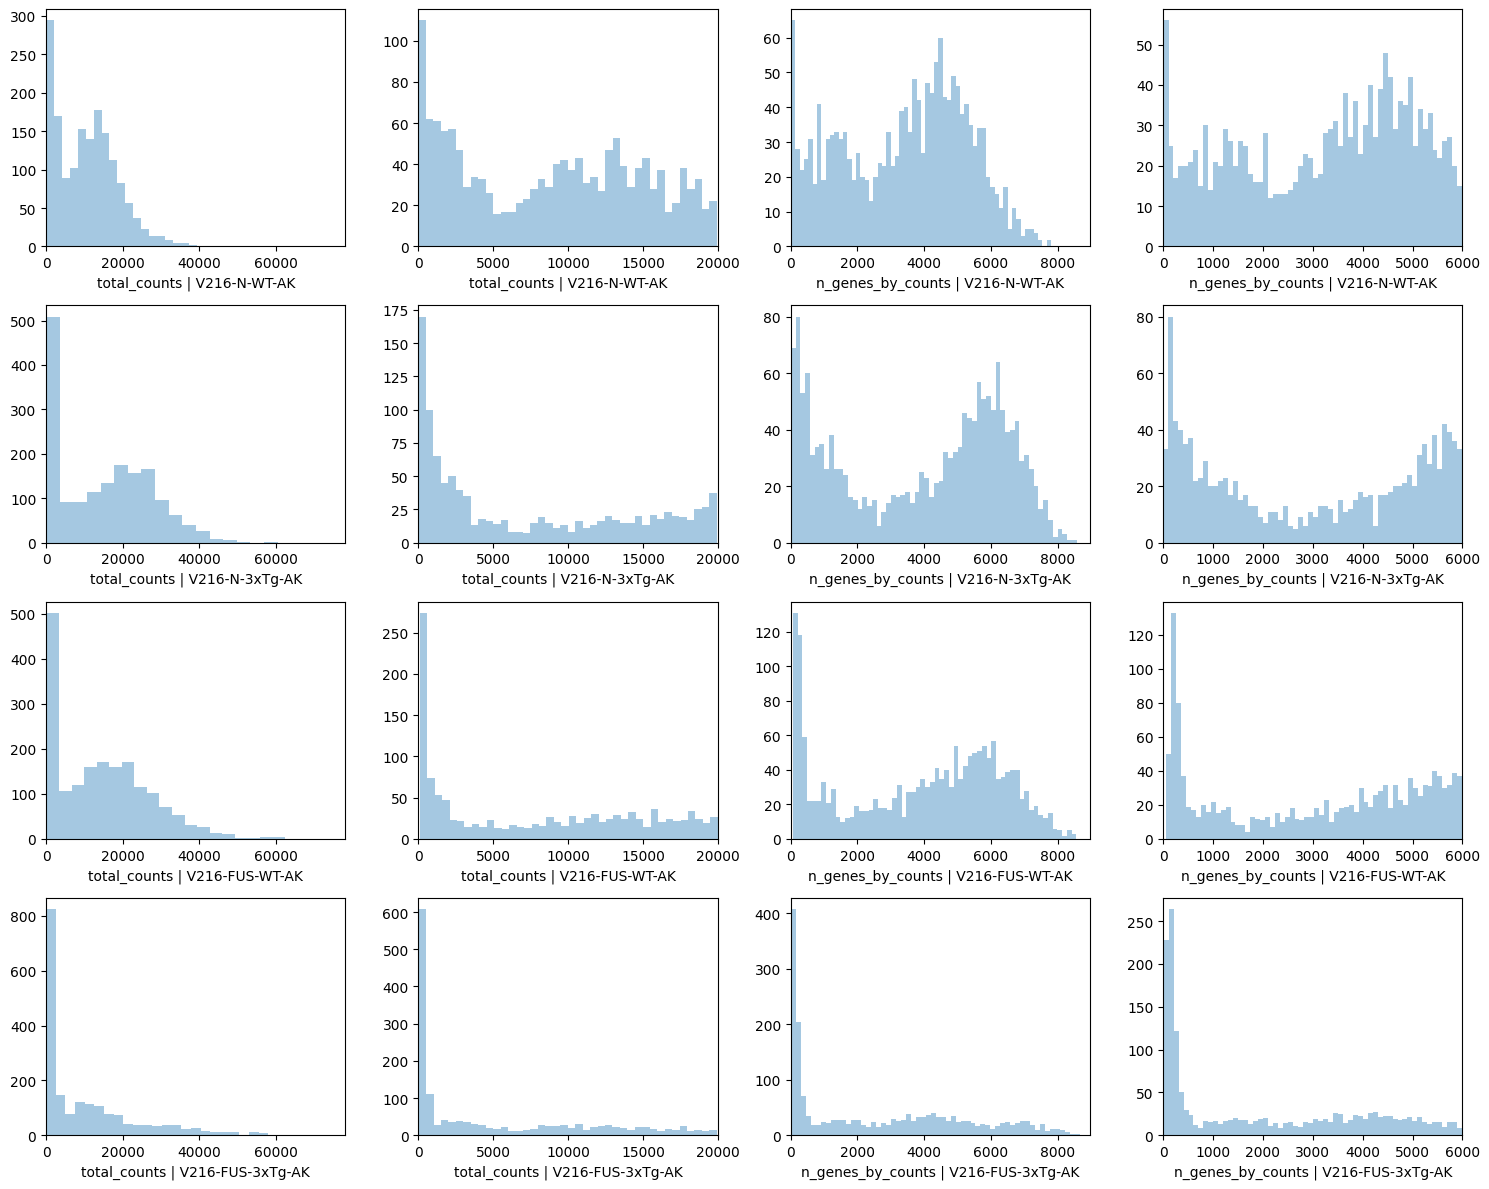

In [9]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata, s)
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

In [10]:
#switching to normal gene names and removing duplicates
adata.var_names=adata.var['SYMBOL']
array = adata.var_names
_, i = np.unique(array, return_index=True)
res = np.zeros_like(array, dtype=bool)
res[i] = True
adata=adata[:,res]

INFO     File                                                                                
         /media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/model.pt
         already downloaded                                                                  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1000:   0%| | 1/1000 [00:00<08:15,  2.02it/s, v_num=1, elbo_train=4.85e+


Anndata setup with scvi-tools version 0.17.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 12309 │
│         n_cells          │ 1630  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V216-N-WT-AK │          0          │
└─────────────────────┴──────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5000/5000: 100%|█| 5000/5000 [25:03<00:00,  3.32it/s, v_num=1, elbo_train=
Sampling global variables, sample: 100%|██████| 999/999 [00:47<00:00, 21.18it/s]


FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = '/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK/SV216-N-WT-AK'.sp.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

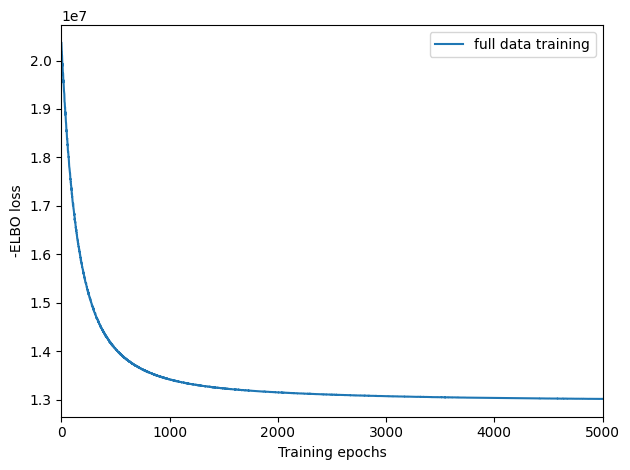

In [11]:
slide = select_slide(adata, 'V216-N-WT-AK')
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(slide.var_names, inf_aver.index)
slide = slide[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=slide, batch_key="sample")
# create and train the model
mod = cell2location.models.Cell2location(
    slide, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()
mod.train(max_epochs=5000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 1000 epochs from the plot
mod.plot_history()
plt.legend(labels=['full data training'])
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
slide = mod.export_posterior(
    slide, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)
slide.obs[slide.uns['mod']['factor_names']] = slide.obsm['q05_cell_abundance_w_sf']
import csv
# Save model
mod.save("Slide_FUS3xtg", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)



In [13]:
# Save anndata object with results
slide_file = "/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/SV216-N-WT-AK.sp.h5ad"
slide.write(slide_file)
slide.write_csvs('/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/SV216-N-WT-AK')

INFO     File                                                                                
         /media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/model.pt
         already downloaded                                                                  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1000:   0%| | 1/1000 [00:00<07:10,  2.32it/s, v_num=1, elbo_train=4.88e+


Anndata setup with scvi-tools version 0.17.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 12309 │
│         n_cells          │ 1822  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V216-FUS-WT-AK │          0          │
└─────────────────────┴────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5000/5000: 100%|█| 5000/5000 [26:26<00:00,  3.15it/s, v_num=1, elbo_train=
Sampling global variables, sample: 100%|██████| 999/999 [00:50<00:00, 19.64it/s]


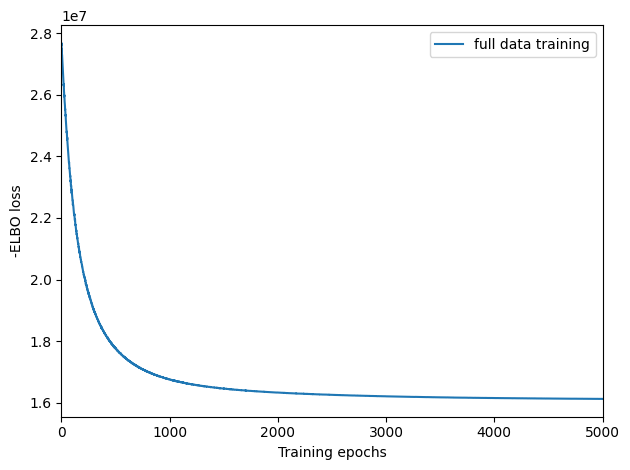

In [14]:
slide = select_slide(adata, 'V216-FUS-WT-AK')
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(slide.var_names, inf_aver.index)
slide = slide[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=slide, batch_key="sample")
# create and train the model
mod = cell2location.models.Cell2location(
    slide, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()
mod.train(max_epochs=5000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 1000 epochs from the plot
mod.plot_history()
plt.legend(labels=['full data training'])
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
slide = mod.export_posterior(
    slide, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)
slide.obs[slide.uns['mod']['factor_names']] = slide.obsm['q05_cell_abundance_w_sf']
import csv
# Save model
mod.save("Slide_FUS3xtg", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
slide_file = "/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/SV216-FUS-WT-AK'.sp.h5ad"
slide.write(slide_file)
slide.write_csvs('/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/SV216-FUS-WT-AK')

INFO     File                                                                                
         /media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/model.pt
         already downloaded                                                                  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1000:   0%| | 1/1000 [00:00<07:49,  2.13it/s, v_num=1, elbo_train=4.82e+


Anndata setup with scvi-tools version 0.17.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 12309 │
│         n_cells          │ 1681  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V216-N-3xTg-AK │          0          │
└─────────────────────┴────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5000/5000: 100%|█| 5000/5000 [25:35<00:00,  3.26it/s, v_num=1, elbo_train=
Sampling global variables, sample: 100%|██████| 999/999 [00:47<00:00, 21.00it/s]


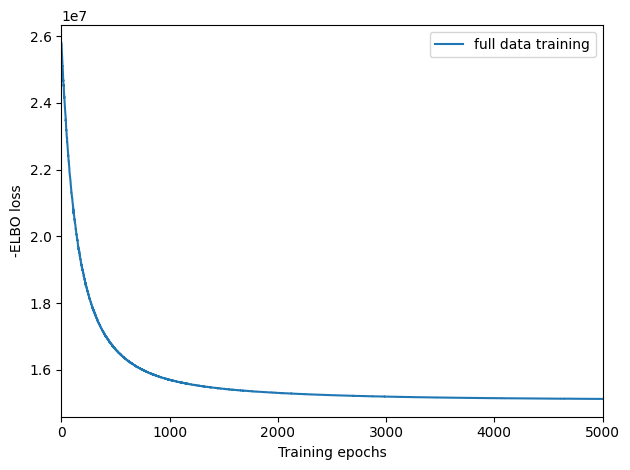

In [15]:
slide = select_slide(adata, 'V216-N-3xTg-AK')
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(slide.var_names, inf_aver.index)
slide = slide[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=slide, batch_key="sample")
# create and train the model
mod = cell2location.models.Cell2location(
    slide, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()
mod.train(max_epochs=5000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 1000 epochs from the plot
mod.plot_history()
plt.legend(labels=['full data training'])
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
slide = mod.export_posterior(
    slide, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)
slide.obs[slide.uns['mod']['factor_names']] = slide.obsm['q05_cell_abundance_w_sf']
import csv
# Save model
mod.save("Slide_FUS3xtg", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
slide_file = "/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/SV216-N-3xTg-AK'.sp.h5ad"
slide.write(slide_file)
slide.write_csvs('/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/SV216-N-3xTg-AK')

INFO     File                                                                                
         /media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/model.pt
         already downloaded                                                                  


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1000:   0%| | 1/1000 [00:00<08:06,  2.06it/s, v_num=1, elbo_train=4.83e+


Anndata setup with scvi-tools version 0.17.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 12309 │
│         n_cells          │ 1894  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                      batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V216-FUS-3xTg-AK │          0          │
└─────────────────────┴──────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5000/5000: 100%|█| 5000/5000 [27:42<00:00,  3.01it/s, v_num=1, elbo_train=
Sampling global variables, sample: 100%|██████| 999/999 [00:53<00:00, 18.75it/s]


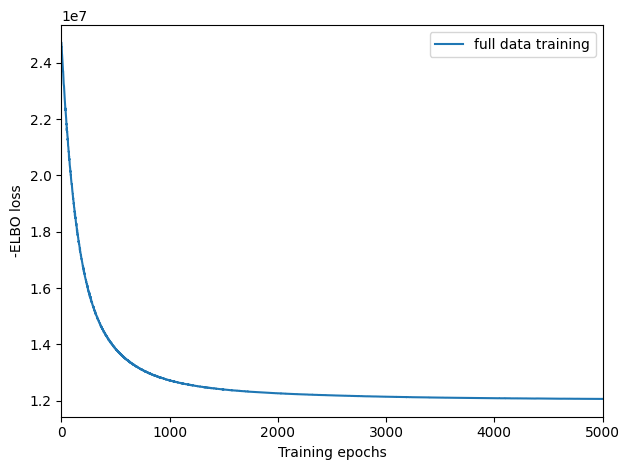

In [16]:
slide = select_slide(adata, 'V216-FUS-3xTg-AK')
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(slide.var_names, inf_aver.index)
slide = slide[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=slide, batch_key="sample")
# create and train the model
mod = cell2location.models.Cell2location(
    slide, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()
mod.train(max_epochs=5000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 1000 epochs from the plot
mod.plot_history()
plt.legend(labels=['full data training'])
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
slide = mod.export_posterior(
    slide, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)
slide.obs[slide.uns['mod']['factor_names']] = slide.obsm['q05_cell_abundance_w_sf']
import csv
# Save model
mod.save("Slide_FUS3xtg", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
slide_file = "/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/SV216-FUS-3xTg-AK.sp.h5ad"
slide.write(slide_file)
slide.write_csvs('/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/SV216-FUS-3xTg-AK')